## Image Colorization with deep convolutional Neural Network


# Step 1 (Mount Google Drive to Access Dataset)


There are also various other techniques you could follow to colorize black and white images with deep learning

In [63]:
import os
from google.colab import drive;
drive.mount("/content/drive", force_remount=True);
drive_file_path = "/content/drive/MyDrive/Colab Notebooks/datasets/galaxy_images/datasets" #we define the file path for the dataset in your google drive
print(os.listdir(drive_file_path));

Mounted at /content/drive
['validation_set', 'training_set']


# Step 2 (Start)


In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import gdown

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Input,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K


tf.random.set_seed(123)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#tf.keras.backend.set_session(sess)
#tf.random.set_seed(2)
np.random.seed(1)

#print(os.listdir(drive_file_path + "/dataset/dataset_updated/"))


In [65]:
#ImagePath= drive_file_path + "/dataset/dataset_updated/training_set/painting/" #OLD
ImagePath= drive_file_path + "/training_set/"

(224, 224, 3)

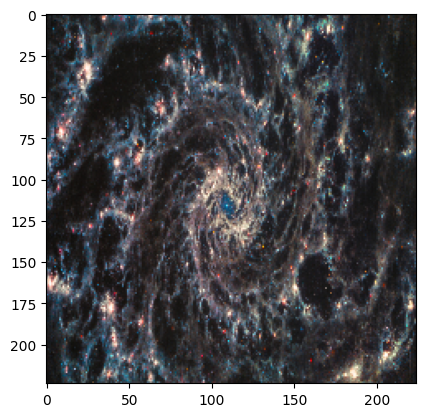

In [66]:
img = cv2.imread(ImagePath+"1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

**Technique to generate colored image from its gray scaled form:-**
Turn the RGB image into LAB image, then separate the L value and ab value from the image and then train the model to predict the ab value**.


In [67]:
HEIGHT=224
WIDTH=224
#ImagePath=drive_file_path + "/dataset/dataset_updated/training_set/painting/" #OLD
ImagePath=drive_file_path + "/training_set/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            #img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)

    return X_img,y_img

In [68]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [69]:
#X_train,X_val,y_train,y_val = train_test_split(X_,y_, random_state=42)

In [70]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)

    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)

    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)

    concat_ = concatenate([model_, in_])

    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)

    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [71]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [72]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 224, 224, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          4,640 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 224, 224, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 112, 112, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 56, 56, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 256)    │          1,024 │ leaky_re_lu_4[0][0]    │
│ (BatchNormalization) 

 Total params: 820,386 (3.13 MB)

 Trainable params: 819,042 (3.12 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [10]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)

Model_Colourization.fit(GenerateInputs(X_,y_),epochs=5,verbose=1,steps_per_epoch=14,shuffle=True)
#Model_Colourization.fit(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=38,shuffle=True)#,validation_data=GenerateInputs(X_val, y_val))

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.2924
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 842ms/step - loss: 0.0000e+00
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0000e+00
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0000e+00


In [73]:
#TestImagePath=drive_file_path + "/dataset/dataset_updated/training_set/iconography/" #OLD
TestImagePath=drive_file_path + "/validation_set/"

In [74]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,224,224,1)

    return img_l_reshaped

# Testcase 1

In [75]:
ImagePath=TestImagePath+"16.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


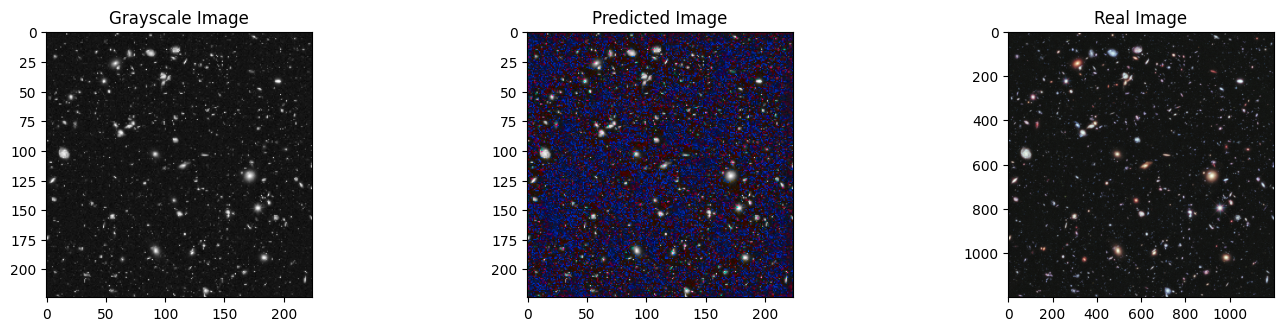

In [76]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"16.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Grayscale Image")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Real Image")
plt.imshow(img_1)

# Testcase 2

In [77]:
ImagePath=TestImagePath+"17.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_1 = Model_Colourization.predict(image_for_test)
Prediction_1 = Prediction_1*128
Prediction_1=Prediction_1.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


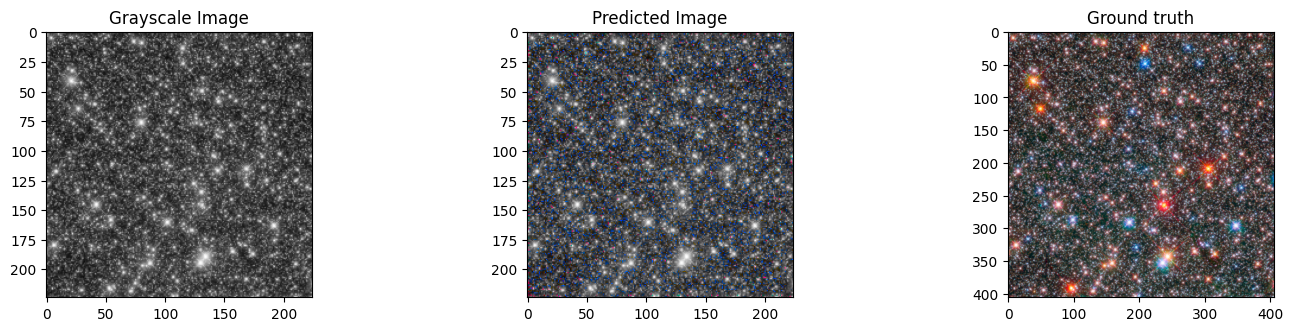

In [78]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"17.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Grayscale Image")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_1
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

# Testcase 3

In [79]:
ImagePath=TestImagePath+"18.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_2 = Model_Colourization.predict(image_for_test)
Prediction_2 = Prediction_2*128
Prediction_2=Prediction_2.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


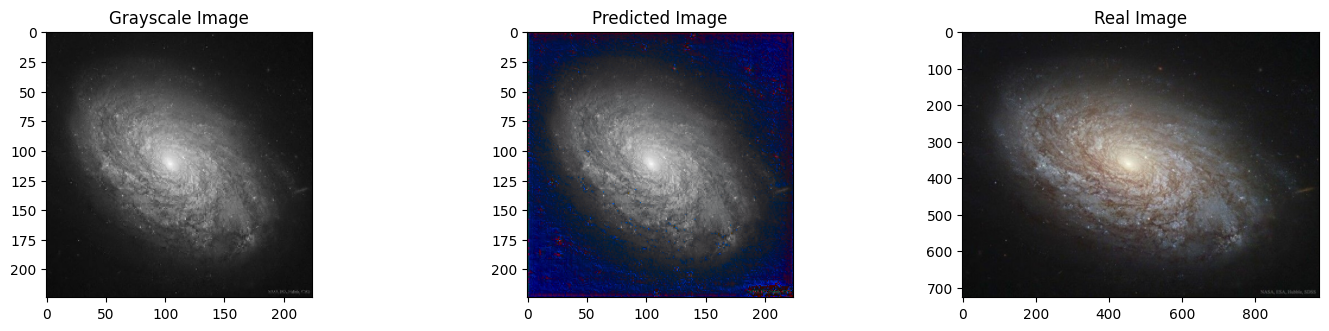

In [80]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"18.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Grayscale Image")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_2
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Real Image")
plt.imshow(img_1)

# Testcase 4

In [81]:
TestImagePath=drive_file_path + "/validation_set/19.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_3 = Model_Colourization.predict(image_for_test)
Prediction_3 = Prediction_3*128
Prediction_3=Prediction_3.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


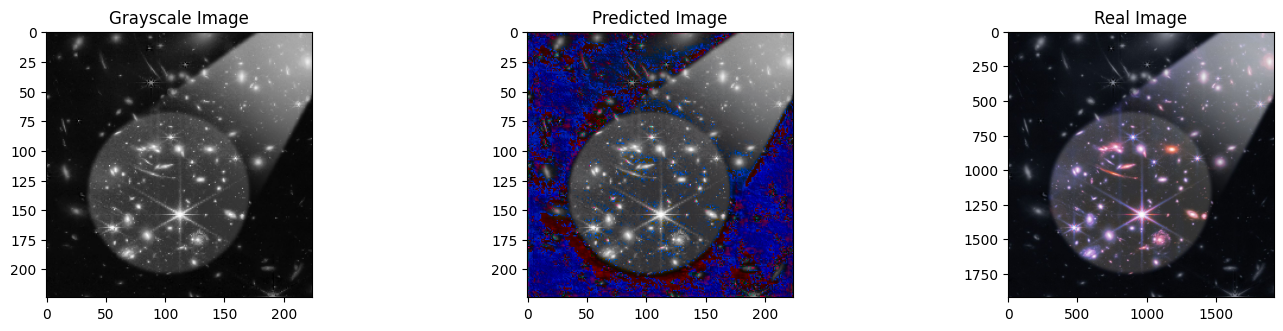

In [82]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Grayscale Image")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_3
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Real Image")
plt.imshow(img_1)

# Testcase 5

In [83]:
TestImagePath=drive_file_path + "/validation_set/20.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_4 = Model_Colourization.predict(image_for_test)
Prediction_4 = Prediction_4*128
Prediction_4=Prediction_4.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


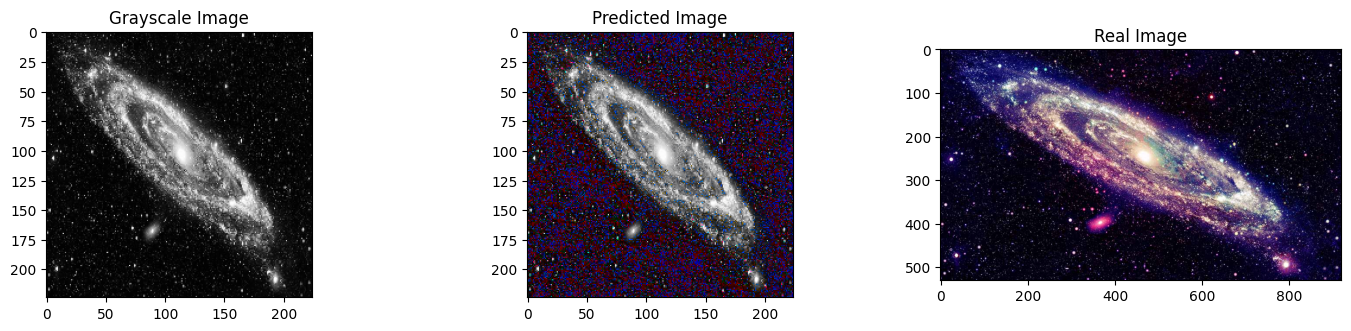

In [84]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Grayscale Image")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_4
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Real Image")
plt.imshow(img_1)

# Testcase 6

In [85]:
TestImagePath=drive_file_path + "/validation_set/21.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_5 = Model_Colourization.predict(image_for_test)
Prediction_5 = Prediction_5*128
Prediction_5=Prediction_5.reshape(224,224,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


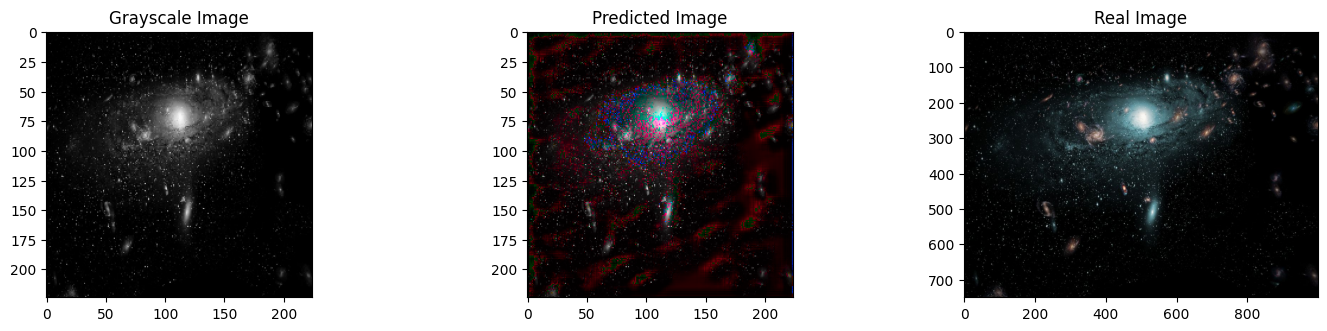

In [30]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Grayscale Image")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_5
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Real Image")
plt.imshow(img_1)